# **Import libraries**

In [1]:
import sys
sys.path.append('/kaggle/input/keras-ssd')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

# **Single Shot MultiBox Detector (SSD)**

In [2]:
img_height = 300
img_width = 480
img_channels = 3

intensity_mean = 127.5
intensity_range = 127.5

n_classes = 5
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

In [3]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

In [4]:
model.load_weights('/kaggle/input/keras-ssd/ssd7_weights.h5')

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [6]:
images_dir = '/kaggle/input/self-driving-cars/images/'

train_labels_filename = '/kaggle/input/self-driving-cars/labels_train.csv'
val_labels_filename   = '/kaggle/input/self-driving-cars/labels_trainval.csv'

In [7]:
train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [8]:
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 18000
Number of images in the validation dataset:	 22241


In [9]:
batch_size = 1

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

In [10]:
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

In [11]:
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# **Training**

In [12]:
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [13]:
model_checkpoint = ModelCheckpoint(filepath='ssd7_weights.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             early_stopping,
             reduce_learning_rate]

In [14]:
def train(model):
    initial_epoch   = 0
    final_epoch     = 20
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=final_epoch,
                                callbacks=callbacks,
                                validation_data=val_generator,
                                validation_steps=ceil(val_dataset_size/batch_size),
                                initial_epoch=initial_epoch)

    plt.figure(figsize=(20,12))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right', prop={'size': 24})

    return model

# **Prediction**

In [15]:
predict_generator = val_dataset.generate(batch_size=6,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [16]:
batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 5

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])
print(len(batch_filenames))

Image: /kaggle/input/self-driving-cars/images/1478021016722623382.jpg

Ground truth boxes:

[[  1 224 139 245 158]
 [  3 317 134 329 157]]
6


In [17]:
y_pred = model.predict(batch_images)

1/1 [==============================] - 1s 1s/step


In [18]:
y_pred_decoded = decode_detections(y_pred * 266.,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[     2.       44.33  32725.83  67737.18  41754.17  76765.52]
 [     2.       44.33  19152.    69059.35  25536.    75443.35]
 [     2.       44.33  24213.83  67737.18  33242.17  76765.52]
 ...
 [     2.       44.33   7318.92  61266.91  11833.09  70295.25]
 [     2.       44.33   5190.91  61266.91   9705.09  70295.25]
 [     5.       44.33  87284.91  38549.92 149835.09 101100.08]]


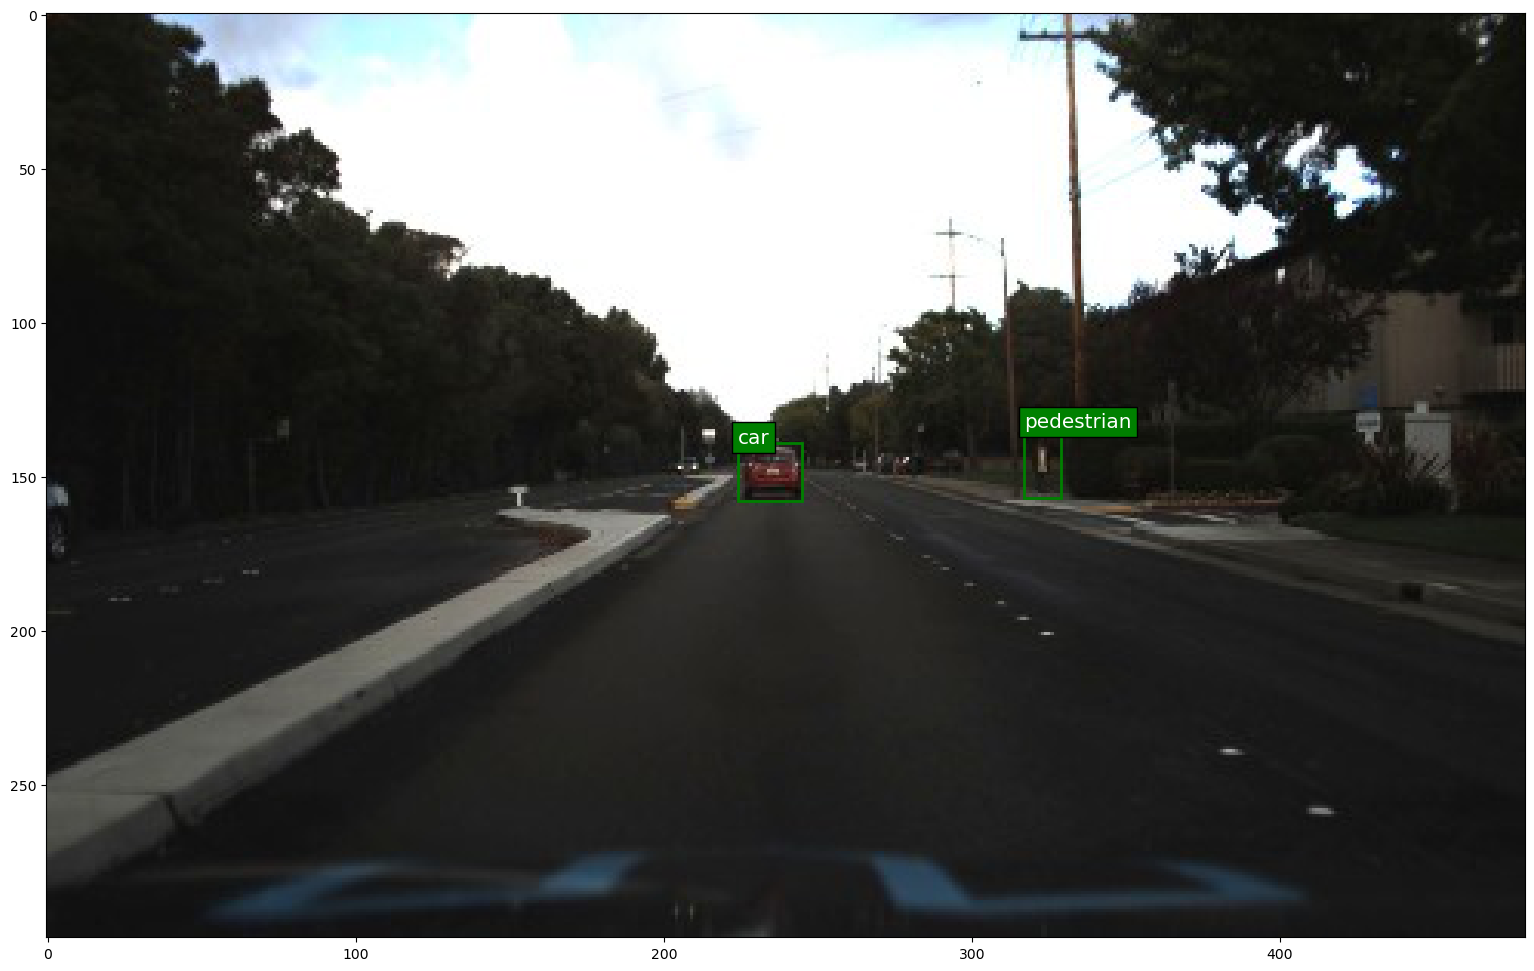

In [19]:
plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
